In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os

In [ ]:
bandit_difficulty = 'restless'
PLAYGROUND_DIR = f"~/logs/EI_RLDM/bandit/{bandit_difficulty}"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
num_episodes = 1000  # Adjust based on training Episodes
num_episodes_colei = 1000
batch_size = 256
n_seeds = 20
grad_clip_list = [1]
rad_list = [1.]
lr_list = [None]
# lr_list = [round(learning_rate, 5) for learning_rate in lr_list]
seeds = [i for i in range(n_seeds)]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(_, _, _, rad, ei_ratio) = para_comb[0]
learning_rates = { "rnn": 1e-3,
    # "colei": 1e-3,
    "danns": 0.8e-3
    }

grad_clips = { "rnn": 1,
    # "colei": 1,
    "danns": 1
    }
# Initialize dictionaries to store losses
models = {
    "rnn": {}, 
    # "colei": {},
    "danns": {}
}
n_hidden = 48

In [5]:
for model_type in models.keys():
    learning_rate = learning_rates[model_type]
    grad_clip = grad_clips[model_type]
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    models[model_type] = {k: np.zeros((n_seeds, num_episodes_p)) for k in ["regret", "train_loss"]}

    for seed in seeds:
        if model_type == "colei":
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_adam.npz"
        else:
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.npz"
            
        if os.path.exists(results_path):
            data = np.load(results_path)
            models[model_type]["train_loss"][seed, :] = data["train_loss"][:num_episodes_p]
            models[model_type]["regret"][seed, :] = data["regret"][:num_episodes_p]
        else:
            print(f"Warning: Missing file {results_path}")

In [6]:
def exp_avg_convolve(arr, alpha):
    kernel = (1 - alpha) ** np.arange(len(arr))
    kernel /= kernel.sum()
    return np.convolve(arr, kernel, mode='full')[:len(arr)]

In [7]:
# Compute mean and standard deviation across seeds
train_loss_mean = {model: np.mean(models[model]["train_loss"], axis=0) for model in models}
train_loss_std = {model: np.std(models[model]["train_loss"], axis=0) for model in models}
regret_mean = {model: np.mean(models[model]["regret"], axis=0) for model in models}
regret_std = {model: np.std(models[model]["regret"], axis=0) for model in models}
regret_mean2 = {model: np.mean(np.array([exp_avg_convolve(models[model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models} 
regret_std2 = {model: np.std(np.array([exp_avg_convolve(models[model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models} 

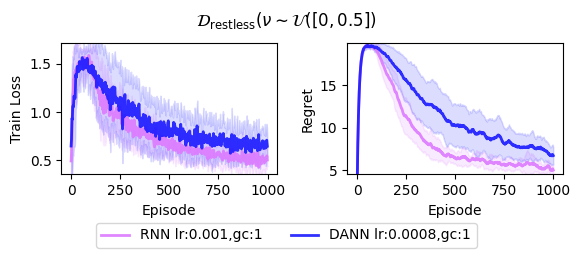

In [9]:
# Plot results
labels = {"rnn": "RNN",
        #   "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-',  '-','-', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
colors = ["#dd7aff","#1a1aff" ,"#17b9ad" ]

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), squeeze=False)
# axes[2, 1].sharey(axes[2, 0])  # Share y-axis only in the second row
# Training Loss


### Train Loss ###
all_loss_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = train_loss_mean[model_type]
    std_values = train_loss_std[model_type]
    loss_values = np.nan_to_num(loss_values, nan=0)
    std_values = np.nan_to_num(std_values, nan=0)

    all_loss_values.extend(loss_values - std_values)
    all_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    
    axes[0, 0].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Train Loss")
# axes[0, 0].legend()

all_loss_values = np.nan_to_num(all_loss_values, nan=0)
y_min, y_max = np.percentile(all_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)


### Test Loss ###
all_test_loss_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = regret_mean2[model_type]
    std_values = regret_std2[model_type]

    all_test_loss_values.extend(loss_values - std_values)
    all_test_loss_values.extend(loss_values + std_values)

    axes[0, 1].plot(loss_values,  color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 1].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Regret")
# axes[0, 1].legend()

y_min, y_max = np.percentile(all_test_loss_values, [1, 99])
axes[0, 1].set_ylim(y_min, y_max)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05))
fig.suptitle(r"$\mathcal{D}_{\mathrm{restless}} (\nu \sim \mathcal{U}([0,0.5])$", y=0.93)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

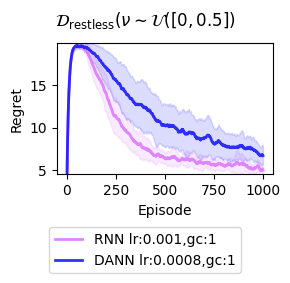

In [ ]:
# Plot results
labels = {"rnn": "RNN",
        #   "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-',  '-','-', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
colors = ["#dd7aff","#1a1aff" ,"#17b9ad" ]

fig, axes = plt.subplots(1, 1, figsize=(3, 2.5), squeeze=False)
# axes[2, 1].sharey(axes[2, 0])  # Share y-axis only in the second row
# Training Loss


### Train Loss ###
# all_loss_values = []
# for i, model_type in enumerate(models.keys()):
#     if model_type == "colei":
#         num_episodes_p = num_episodes_colei
#     else:
#         num_episodes_p = num_episodes
#     loss_values = train_loss_mean[model_type]
#     std_values = train_loss_std[model_type]
#     loss_values = np.nan_to_num(loss_values, nan=0)
#     std_values = np.nan_to_num(std_values, nan=0)

#     all_loss_values.extend(loss_values - std_values)
#     all_loss_values.extend(loss_values + std_values)

#     axes[0, 0].plot(loss_values, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    
#     axes[0, 0].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

# axes[0, 0].set_xlabel("Episode")
# axes[0, 0].set_ylabel("Train Loss")
# # axes[0, 0].legend()

# all_loss_values = np.nan_to_num(all_loss_values, nan=0)
# y_min, y_max = np.percentile(all_loss_values, [1, 99])
# axes[0, 0].set_ylim(y_min, y_max)


### Test Loss ###
all_test_loss_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = regret_mean2[model_type]
    std_values = regret_std2[model_type]

    all_test_loss_values.extend(loss_values - std_values)
    all_test_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values,  color=colors[i],  label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 0].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Regret")
# axes[0, 1].legend()

y_min, y_max = np.percentile(all_test_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels,loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.15))
fig.suptitle(r"$\mathcal{D}_{\mathrm{restless}} (\nu \sim \mathcal{U}([0,0.5])$", y=0.93)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()